In [29]:
import seaborn as sns

taxi = sns.load_dataset('taxis')
taxi.info()
subtaxi = taxi.loc[:, ['passengers', 'distance', 'fare', 'tip', 'tolls', 'total']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6433 entries, 0 to 6432
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   pickup           6433 non-null   datetime64[ns]
 1   dropoff          6433 non-null   datetime64[ns]
 2   passengers       6433 non-null   int64         
 3   distance         6433 non-null   float64       
 4   fare             6433 non-null   float64       
 5   tip              6433 non-null   float64       
 6   tolls            6433 non-null   float64       
 7   total            6433 non-null   float64       
 8   color            6433 non-null   object        
 9   payment          6389 non-null   object        
 10  pickup_zone      6407 non-null   object        
 11  dropoff_zone     6388 non-null   object        
 12  pickup_borough   6407 non-null   object        
 13  dropoff_borough  6388 non-null   object        
dtypes: datetime64[ns](2), float64(5), int64(

In [30]:
import numpy as np
# create missingness
np.random.seed(42)
mask1 = subtaxi.total > 25
mask2 = np.random.randn(taxi.shape[0]) > 0.7

subtaxi_missing = subtaxi.copy()
subtaxi_missing.loc[mask1 & mask2, 'tip'] = np.nan

subtaxi_missing

,passengers,distance,fare,tip,tolls,total
0,1,1.60,7.0,2.15,0.0,12.95
1,1,0.79,5.0,0.00,0.0,9.30
2,1,1.37,7.5,2.36,0.0,14.16
3,1,7.70,27.0,NaN,0.0,36.95
4,3,2.16,9.0,1.10,0.0,13.40
...,...,...,...,...,...,...
6428,1,0.75,4.5,1.06,0.0,6.36
6429,1,18.74,58.0,0.00,0.0,58.80
6430,1,4.14,16.0,0.00,0.0,17.30
6431,1,1.12,6.0,0.00,0.0,6.80


<Axes: >

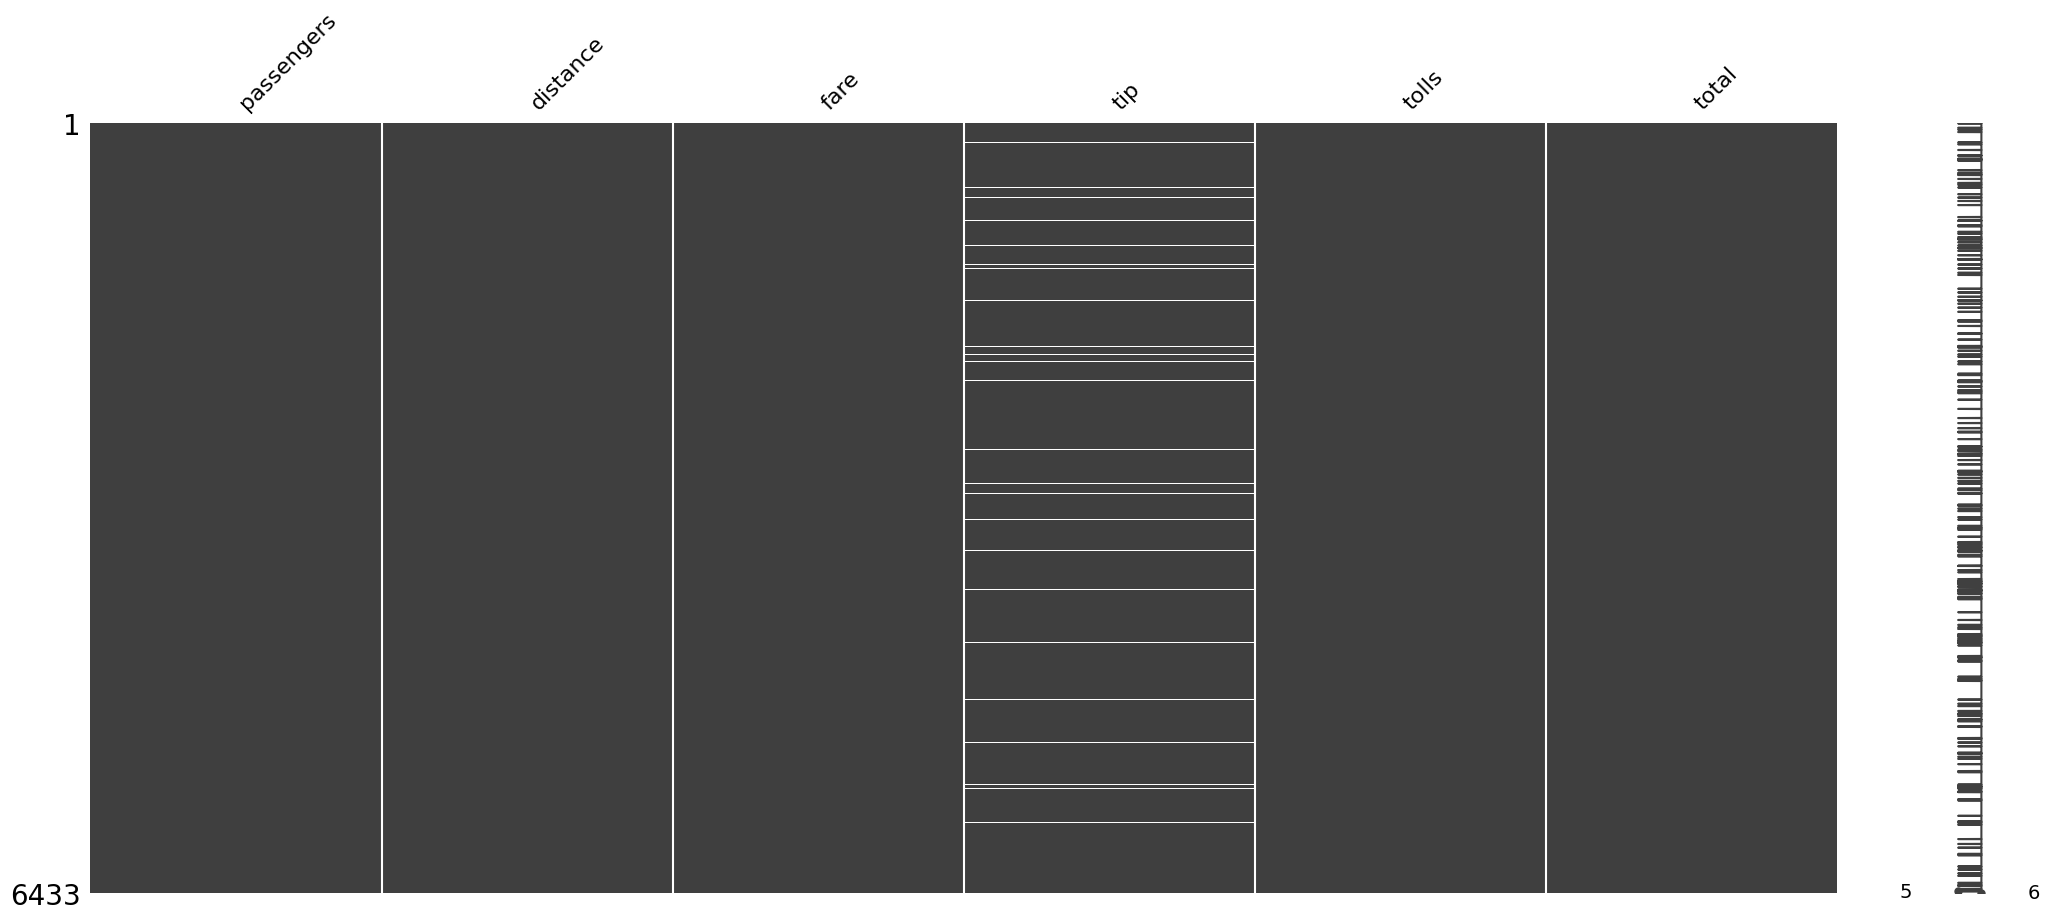

In [31]:
import missingno as msno

msno.matrix(subtaxi_missing)

In [ ]:
import miceforest as mf
from sklearn.impute import KNNImputer
import missingno as msno
import matplotlib.pyplot as plt

# Mean imputation
subtaxi_mean = subtaxi_missing.copy()
subtaxi_mean['tip'] = subtaxi_mean['tip'].fillna(subtaxi_mean['tip'].mean())
# Median imputation
subtaxi_median = subtaxi_missing.copy()
subtaxi_median['tip'] = subtaxi_median['tip'].fillna(subtaxi_median['tip'].median())
# KNN imputation
subtaxi_knn = subtaxi_missing.copy()
fs = ['fare', 'distance', 'passengers', 'tip']
imputer = KNNImputer(n_neighbors=5)
subtaxi_knn[fs] = imputer.fit_transform(subtaxi_knn[fs])
# Predictive Mean Matching imputation
kernel = mf.ImputationKernel(
    data=subtaxi_missing[fs],
    save_all_iterations_data=True,
    random_state=42
)
kernel.mice(3)
subtaxi_pmm = kernel.complete_data(0)



(6433, 4)

In [41]:
from sklearn.metrics import mean_squared_error
# computing RMSEs
imputed_mask = subtaxi_missing['tip'].isna()
RMSE_mean = np.sqrt(mean_squared_error(subtaxi.loc[imputed_mask,'tip'], subtaxi_mean.loc[imputed_mask,'tip']))
RMSE_median = np.sqrt(mean_squared_error(subtaxi.loc[imputed_mask,'tip'], subtaxi_median.loc[imputed_mask,'tip']))

RMSE_knn = np.sqrt(mean_squared_error(subtaxi.loc[imputed_mask,'tip'], subtaxi_knn.loc[imputed_mask,'tip']))
RMSE_pmm = np.sqrt(mean_squared_error(subtaxi.loc[imputed_mask,'tip'], subtaxi_pmm.loc[imputed_mask,'tip']))

print(f"Mean RMSE: {RMSE_mean:.4f}")
print(f"Median RMSE: {RMSE_median:.4f}")
print(f"KNN RMSE: {RMSE_knn:.4f}")
print(f"PMM RMSE: {RMSE_pmm:.4f}")

Mean RMSE: 5.7588
Median RMSE: 5.8776
KNN RMSE: 4.5656
PMM RMSE: 5.2414
